In [566]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import pi

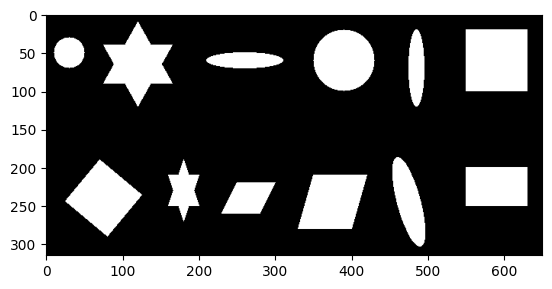

In [567]:
# Do not change this cell
I = cv2.imread('shapes.jpg')    # Reading image
img = cv2.cvtColor(I,cv2.COLOR_BGR2GRAY)    # Converting image to grayscale
_,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)    # Spiliting values between 0 and 1
plt.imshow(img,cmap='gray')    # Displaying image
plt.show()

In [568]:
def compactness(contours):
    '''
    You should implement one of the descriptors in this method (compactness, ...)
    You can change name of this method.
    You can copy this cell and implement another descriptor in next cell.
    You can create as many descriptor as you want.
    For more information, refer to https://docs.opencv.org/4.x/d1/d32/tutorial_py_contour_properties.html
    input(s):
    contours (ndarray): contour of the shape
    output(s):
    output (float): computed feature value by applying the descriptor on the contour
    '''
    m=contours[:-1] - contours[1:]
    n=[contours[-1] - contours[0]]
    
    # surr=cv2.contourArea(contour)
    # con_dist=np.concatenate((m,n),axis=0)
    # con_ord=np.linalg.norm(con_dist,axis=1)
    # p=np.sum(con_ord)
    # outp=4*pi * float(surr)/(p**2)
    # return outp
    
    era = cv2.contourArea(contours)
    con_dis = np.concatenate((m,n), axis=0)
    con_ord = np.linalg.norm(con_dis, axis=-1)
    p = np.sum(con_ord)
    output = 4 * pi * float(era) / (p**2)
    return output



In [569]:
def solidity(contours):   
    era = cv2.contourArea(contours)
    con_hull = cv2.convexHull(contours)
    con_era = cv2.contourArea(con_hull)
    outp = float(era) / con_era
    return outp

In [570]:
def axis_find(contours):
    # Crease a list of border points, by computing the distance between adjecent contour points,
    # then adding extra points along the line between adjecent points,
    # This is to raise the amount of defining points for the shape
    # so the fitEllipse function can be used, as it requires at least 5 points
    m=contours[:-1] - contours[1:]
    n=[contours[-1] - contours[0]]
    con_dis = np.concatenate((m,n), axis=0)
    con_ord = np.linalg.norm(con_dis, axis=-1).astype(int)
    border = np.concatenate([np.linspace(contours[i], contours[i+1], con_ord[i].item()) for i in range(contours.shape[0]-1)] 
                            + [np.linspace(contours[-1], contours[0], con_ord[-1].item())]).astype(np.float32)

    a,(min_axis,ma_axis),b = cv2.fitEllipse(border)
    output = min_axis / ma_axis

    return output


In [571]:
def info_contour(contour):
    # Return an array of contour features, all between 0 and 1
    return np.array((
        compactness(contour),
        solidity(contour),
        axis_find(contour),
    ))

In [572]:
def distance_criteria(x,y):
    """
    You should implement your distance criteria here.
    This method is used for comparing features of shapes.
    input(s):
    x (ndarray): feature vector of first shape with the shape of (n,). (n is number of features) 
    y (ndarray): feature vector of second shape with the shape of (n,). (n is number of features)
    output(s):
    output (float): Distance between features of two shapes
    """
    w = np.array([
        1.0,
        0.33,
        0.11,
    ])
    outp = np.linalg.norm((x - y) * w, axis=-1)
    return outp

In [573]:
contours, _ = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    # calculating contours

In [574]:
# In this cell, you should use contours that we calculated in the previous cell and 
# your defined descriptors to extract features for each shape.
# These features should be a numpy array with the shape of (m,n), where m is the number of shapes and n is the number of features.
feature = np.stack(list(map(info_contour, contours)), axis=0)
num_shape, num_feat = feature.shape
print(num_shape,num_feat)

12 3


In [575]:
def grouping(features, threshold):
    """
    split feature between multiple groups based on their distance from each other.
    input(s):
    features (ndarray): a numpy array with the shape of (m,n), where m is the number of shapes and n is the number of features
    threshold (float): maximum distance between two feature vector which determine wether they should be in the same group or not.
    output(s):
    output (list): group of each shape. For example, [[1,2],[3,4,5]] means 1 and 2 are in the same group and 3 and 4 and 5 are in another group.
    """
    groups = list()
    groups.append([features[0],[0]])
    for i, feature in enumerate(features[1:]):
        new_group_flag = True
        for group in groups:
            if distance_criteria(group[0], feature) < threshold:
                group[1].append(i+1) 
                new_group_flag = False
                break
        if new_group_flag:
            groups.append([feature,[i+1]])
    return [[idx for idx in group[1]] for group in groups]

In [576]:
def painting(groups, contours, colors):
    """
    paint shapes base on their groups.
    input(s):
    groups (list): group of each shape. The format is as same as the output of grouping method.
    contour (ndarray): contour of the shape
    colors (list): color of each group
    """
    result = I.copy()
    for group, color in zip(groups,colors):
        for idx in group:
            plt.imshow(cv2.drawContours(result,contours,idx,color,4))
    plt.show()

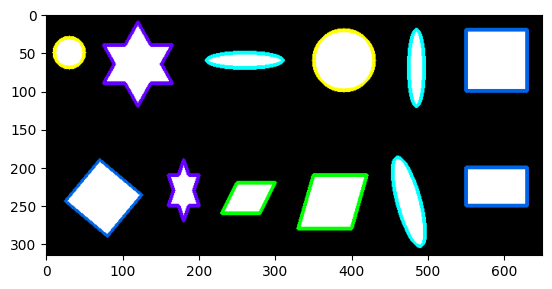

In [577]:
# You should replace your features array with None
colors = [(0,255,0),(0,100,230),(100,0,255),(0,255,255),(255,255,0)]
groups = grouping(feature,0.08)
painting(groups, contours, colors)